In [4]:
from photutils import EllipticalAperture
from marvin.tools.maps import Maps

import pandas as pd
import numpy as np
import copy

In [6]:
import sys
sys.path.insert(0, '/home/sshamsi/Projects/gz3d_spirals/GZ3D_production')

import gz3d_fits

In [7]:
class SpiralGalaxy(object):
    """Represents a spiral galaxy ready for SFR analysis.
    
    This class represents a spiral galaxy and utilises the
    GZ3D code's gz3d_fits class and Marvin's Map class
    to obtain spiral masks as well as emission maps and
    galaxy information respectively. It produces a pandas
    dataframe. The dataframe specifies radial and
    spiral information which can be used for analysis.
    
    Attributes:
        data (gz3d_fits): Is the galaxy class from the GZ3D module.
        spax_df (pandas dataframe): Lists individual spaxels with SFR and spiral details.
    """
    
    def __init__(self, file_path):
        """initialises galaxy with certain methods variables and methods.
        
        Taking in file path for GZ3D .FITS, the class is initialised by
        initialising the `gz3d_fits` class, initialising variables like
        the MaNGA ID, Marvin Maps class attributes like the emission maps,
        and function 'switches' to make sure resource intensive methods are
        only run once.
        
        Args:
            file_path (str): File path to the GZ3D .FITS file.
        """
        
        self.file_path = file_path
        self.data = gz3d_fits.gz3d_fits(file_path)
        self.mangaid = self.data.metadata['MANGAID'][0]
        
        self.maps = Maps(self.mangaid)
        self.hamap = self.maps.emline_gflux_ha_6564
        self.hbmap = self.maps.emline_gflux_hb_4862
        self.eff_rad = self.maps.nsa['elpetro_th50_r'] * 2
        self.redshift = self.maps.nsa['z']
        self.mass = self.maps.nsa['sersic_mass']
        self.elpetro_ba = self.maps.nsa['elpetro_ba']
        self.theta = np.radians(self.maps.nsa['elpetro_phi'] - 90.0)
        
        self.flux_df_loaded = False
        self.sfr_cols_loaded = False
        self.ellipical_mask_loaded = False
        self.ellipical_cutout_on = True
        
        
    def __repr__(self):
        """Represent galaxy with MaNGA ID"""
        
        return 'MaNGA ID {}'.format(self.mangaid)
        
        
    def check_usability(self, threshold = 5, pix_percentage = 1.5):
        """Checks to see if the galaxy is suitable for analysis.
        
        The method checks the raw spiral mask from the gz3d_fits class
        to confirm if the number of times the visual image pixel was marked
        (threshold) is greater than some number, and if the total area
        covered by these pixels is greater than the percentage specified.

        Args:
            threshold (int): Pixels should be marked >= this number of times.
            pix_percentage (float): Marked pixes above the threshold must be greater than this percentage of total.
            
        Returns:
            True if useful, False otherwise.
        """
        
        image_spiral_mask = self.data.spiral_mask
        pixels_above_threshold = (image_spiral_mask >= threshold).sum()
                
        if (pixels_above_threshold * 100 / image_spiral_mask.size < pix_percentage):
            return False
        
        return True
    
        
    def form_flux_df(self):
        """Forms the main dataframe with all spaxels and their flux.
        
        This method forms the main dataframe for the galaxy by gathering the H-alpha
        emission map cutouts with spiral and non-spiral masks applied as well as the
        H-beta map cutout. The cutouts are then fed into the make_spaxel_dicts
        method which then produces a list of dictionaries ready to be applied to the
        pandas dataframe.
        """
        
        if not self.flux_df_loaded:
            spiral_hamap_cutout, non_spiral_hamap_cutout = self.make_hamap_cutouts()
            hbmap_cutout = self.apply_ellipse_cutout(self.hbmap)
            
            combined_dicts = self.make_spaxel_dicts(spiral_hamap_cutout, hbmap_cutout, 'Spiral') + self.make_spaxel_dicts(non_spiral_hamap_cutout, hbmap_cutout, 'Non Spiral')
            
            self.spax_df = pd.DataFrame(combined_dicts, columns = ['radius', 'ha_flux', 'sig_ha_flux', 'hb_flux', 'sig_hb_flux', 'spaxel_type'])
            self.spax_df['r_re'] = self.spax_df['radius']/self.eff_rad
            
            self.flux_df_loaded = True
            
    
    def form_sfr_cols(self):
        """Forms the SFR and sigma(SFR) columns in spax_df.
        
        This method traverses the main pandas dataframe and forms two new columns
        for the SFR and the error in the SFR respectively.
        """
        
        if not self.sfr_cols_loaded:
            self.form_flux_df()
            
            self.spax_df['sfr'] = self.spax_df.apply(lambda row: self.flux2sfr(row), axis=1)
            self.spax_df['sig_sfr'] = self.spax_df.apply(lambda row: self.flux2sfr(row, stdv = True), axis=1)
            self.sfr_cols_loaded = True
    
    
    def make_hamap_spiral_masks(self):
        """Forms the global spiral and non-spiral masks for the H-alpha emission map.
        
        This method creates global (class-wide) H-alpha emission map masks. One of these
        is for spiral and the other for the non-spiral requirement. The reason for these
        being class-wide is that this mask can be used for Flux/SFR calculation as well as
        emission map plots. The maps are formed by taking the H-alpha map mask and adding
        the non/spiral requirement through adding the 'Do not use' 2**30 bitmask.
        
        Note:
            The BPT requirement has not been applied to these masks.
        """
        
        self.get_arms_spaxel_mask()
        
        mask_non_spirals = (~self.arms_spaxel_mask) * self.hamap.pixmask.labels_to_value('DONOTUSE')
        mask_spirals = (self.arms_spaxel_mask) * self.hamap.pixmask.labels_to_value('DONOTUSE')
        
        self.hamap_spiral_mask = copy.deepcopy(self.hamap.mask) | mask_non_spirals
        self.hamap_non_spiral_mask = copy.deepcopy(self.hamap.mask) | mask_spirals
        
    
    def apply_bpt(self, mask):
        """Applies the BPT requirement to any input mask.
        
        This method uses the get_bpt method of the Marvin Maps class to gather a boolean mask
        of spaxels which have been marked as Composite, AGN, Seyfert, or LINER. Since these
        are spaxels we don't wish to use, we make a mask with the 2**30 'Do not use' Bitmask
        with the boolean mask and then apply it to any input mask.

        Args:
            mask (int array): Any emission map mask array to which we may add the BPT requirement.

        Returns:
            mask (int array): Emission map mask array with the BPT requirement added.
        """
        
        bpt_masks = self.maps.get_bpt(return_figure=False, show_plot=False)
        
        comp = bpt_masks['comp']['global']
        agn = bpt_masks['agn']['global']
        seyfert = bpt_masks['seyfert']['global']
        liner = bpt_masks['liner']['global']
        
        overall_bpt_mask = np.logical_or(np.logical_or(np.logical_or(comp, agn), seyfert), liner) * 1073741824
        
        return mask | overall_bpt_mask
        
        
    def apply_ellipse_cutout(self, array):
        """Applies an elliptical cutout to any given array according to galaxy specifications.
        
        This method uses the `astropy` Elliptical Aperture module to make an elliptical cutout
        of the galaxy by takingx into account the Petrosian effective radius, inclination, and
        b/a ratio for a galaxy. A cutout from the centre of  the array is then returned with
        this requirement applied. The primary reason for working with cutouts is speed of
        analysis.
        
        Args:
            array (array): Any array, which is an emission map with a modified mask in our use.

        Returns:
            array (array): An elliptical cutout of the array 
        """
        
        if self.ellipical_mask_loaded == False:
            x, y = self.hamap.shape
            
            ellipical_aperture = EllipticalAperture([(x-1)/2, (y-1)/2], np.ceil(self.eff_rad), np.ceil(self.eff_rad * self.elpetro_ba), self.theta)
            self.mask_ellipical = ellipical_aperture.to_mask(method = 'exact')[0]
            
            self.ellipical_mask_loaded = True
        
        return self.mask_ellipical.cutout(array)
    
    
    def make_hamap_cutouts(self):
        """An overarching method which forms the non/spiral H-alpha map cutouts.
        
        This method forms the spiral and non-spiral H-alpha emission map cutouts
        by applying the BPT requirement to the global H-alpha emission map masks.
        The modified maps are then cut out and returned.

        Returns:
            emission map cutouts (emap touple): Cutouts for the H-alpha spiral and non-spiral maps
        """
        
        self.make_hamap_spiral_masks()
        
        # We apply the BPT requirement to the global spiral and non-spiral masks, which can be removed for non-spiral analyses
        modified_ha_spiral_mask = self.apply_bpt(copy.deepcopy(self.hamap_spiral_mask))
        modified_ha_non_spiral_mask = self.apply_bpt(copy.deepcopy(self.hamap_non_spiral_mask))
        
        modified_spiral_hamap = copy.deepcopy(self.hamap)
        modified_spiral_hamap.mask = modified_ha_spiral_mask
        
        modified_non_spiral_hamap = copy.deepcopy(self.hamap)
        modified_non_spiral_hamap.mask = modified_ha_non_spiral_mask
        
        if self.ellipical_cutout_on:
            spiral_hamap_cutout = self.apply_ellipse_cutout(modified_spiral_hamap)
            non_spiral_hamap_cutout = self.apply_ellipse_cutout(modified_non_spiral_hamap)
            
            return spiral_hamap_cutout, non_spiral_hamap_cutout
        
        return modified_spiral_hamap, modified_non_spiral_hamap
        
        
    def make_spaxel_dicts(self, ):
        """Takes in H-alpha and H-beta emission maps and returns fluxes for all spaxels in a dict list.
        
        This method taked in H-alpha and H-beta maps and goes through the spaxels to create a dictionary
        with flux information on it for each usable spaxel. In our use the emission maps are cutouts of
        galaxies made for efficiency. We also input modified H-alpha maps with the non/spiral and BPT
        requirement also present to mark spaxels as either spiral or non-spiral.
        
        Args:
            hamap_cut (DAP map): H-alpha map for spaxel flux collection.
            hbmap_cut (DAP map): H-beta map for spaxel flux collection.
            spaxel_type (str): The designation of the spaxel as either spiral or non-spiral

        Returns:
            dict_list (list of dictionaries): Contains all spaxel information in dictionaries.
        """
        
        dict_list = []
        
        a, b = hamap_cut.shape #shape of the cutout
        k, h = (a-1)/2.0, (b-1)/2.0 #mapcentre
                
        for y, x in [(y, x) for y in range(a) for x in range(b)]:
            if hamap_cut.mask[y, x] & 1073741824 != 0:
                continue
                
            ha_flux = hamap_cut[y, x].value
            ha_stdv = hamap_cut[y, x].error.value
            
            hb_flux = hbmap_cut[y, x].value
            hb_stdv = hbmap_cut[y, x].error.value
            
            j, i = (-1*(y-k), x-h) #vector from centre
            
            spax_angle = (np.arctan(j/i)) - self.theta
            spax_r = (j**2.0 + i**2.0)**0.5
            spax_r_int = np.ceil(spax_r * ((np.cos(spax_angle))**2.0 + ((np.sin(spax_angle))/self.elpetro_ba)**2.0)**0.5)
            
            if (hbmap_cut.mask[y, x] & 1073741824 != 0 or hb_flux <= 0):
                dict_list.append({'radius': spax_r_int, 'ha_flux': ha_flux, 'sig_ha_flux': ha_stdv, 'hb_flux': np.nan, 'sig_hb_flux': np.nan, 'spaxel_type': spaxel_type})
            else:
                dict_list.append({'radius': spax_r_int, 'ha_flux': ha_flux, 'sig_ha_flux': ha_stdv, 'hb_flux': hb_flux, 'sig_hb_flux': hb_stdv, 'spaxel_type': spaxel_type})
                
        return dict_list
    
    
    def get_lgmass(self):
        """Returns log base 10 of galactic mass."""
        
        return np.log10(self.mass)
        
        
    def get_arms_spaxel_mask(self):
        """Obtains the base spaxel mask for spiral arms, and makes a boolean version of it available."""
        
        self.data.make_all_spaxel_masks(grid_size = self.hamap.shape)
        self.arms_spaxel_mask = self.data.spiral_mask_spaxel > 3
        
        
    def get_integrated_sfr(self, mode = 'all', filter_radii = 0):
        self.form_sfr_cols()
        
        df = self.spax_df[self.spax_df.notnull()]
        df = df[df['r_re'] <= 1 and df['r_re'] >= filter_radii]
        
        
        if mode == 'all':
            return df.sfr.sum(), ((df['sig_sfr'] ** 2).mean()) ** 0.5
        
        if mode == 'spirals':
            return df[df.spaxel_type == 'Spiral'].sfr.sum(), ((df[df.spaxel_type == 'Spiral']['sig_sfr'] ** 2).mean()) ** 0.5
        
        if mode == 'non-spirals':
            return df[df.spaxel_type == 'Non Spiral'].sfr.sum(), ((df[df.spaxel_type == 'Non Spiral']['sig_sfr'] ** 2).mean()) ** 0.5
        
        return "mode must be set as 'all', 'spirals', or 'non-spirals'"
    
    
    def flux2sfr(self, row, stdv = False):
        """Takes in pandas row from the main dataframe and returns SFR or sigma(SFR).
        
        This method is designed to be used with the pandas df.apply function. It takes in a row from
        the main dataframe and uses it to calculate the SFR and it's uncertainty. It used the H-alpha
        and H-beta flux to calculate luminosities, which are used to obtain a corrected H-alpha
        luminosity. After this either the SFR or SFR standard deviation from it is retuened depending
        on the value of stdv.
        
        Args:
            row (pandas row): Contains needed flux information.
            stdv (boolean): Optional boolean value can be used to obtain either the magnitude or flux in SFR.
            
        Returns:
            sigma/SFR (float): The value of the sigma/SFR.
        """
        
        ha_flux = row['ha_flux']
        hb_flux = row['hb_flux']
        
        dis = (299792 * self.redshift / 70) * (3.08567758128E+22) # in metres
        dis_kpc = (299792 * self.redshift / 70) * 1E3
        
        lum_ha = ha_flux * (4 * np.pi * (dis ** 2)) * 1E-13
        lum_hb = hb_flux * (4 * np.pi * (dis ** 2)) * 1E-13
        
        corrected_ha_lum = lum_ha * ((lum_ha/lum_hb)/2.8) ** 2.36
        
        if stdv:
            ha_stdv = row['sig_ha_flux']
            hb_stdv = row['sig_hb_flux']
            
            lum_ha_stdv = ha_stdv * (4 * np.pi * (dis ** 2)) * 1E-13
            lum_hb_stdv = hb_stdv * (4 * np.pi * (dis ** 2)) * 1E-13
            
            corrected_ha_lum_stdv = (((3.36 * lum_ha ** 2.36 * lum_ha_stdv)/((2.8 * lum_hb) ** 2.36)) ** 2 \
                            + ((-2.36 * lum_ha ** 3.36 * lum_hb_stdv)/(2.8 ** 2.36 * lum_hb ** 3.36)) ** 2) ** 0.5
            
            return (corrected_ha_lum_stdv / 10 ** 41.1) / ((dis_kpc * 0.0000024240684055) ** 2)
            
        return (corrected_ha_lum / 10 ** 41.1) / ((dis_kpc * 0.0000024240684055) ** 2)

In [9]:
gal = SpiralGalaxy('/home/sshamsi/sas/mangawork/manga/sandbox/galaxyzoo3d/v1_0_0/1-147485_127_5679396.fits.gz')

/home/sshamsi/miniconda3/envs/gz3d/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/sshamsi/miniconda3/envs/gz3d/lib/python3.7/site-packages/marvin/utils/general/general.py:1085: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  value = np.asscalar(value)


In [10]:
gal.form_sfr_cols()

In [11]:
gal.spax_df

,radius,ha_flux,sig_ha_flux,hb_flux,sig_hb_flux,spaxel_type,r_re,sfr,sig_sfr
0,23.0,3.232861,0.052111,0.908988,0.056351,Spiral,1.261843,0.009195,0.001434
1,25.0,4.943520,0.051913,1.221412,0.042471,Spiral,1.371569,0.019076,0.001704
2,26.0,5.290386,0.053114,1.299799,0.041815,Spiral,1.426432,0.020687,0.001719
3,26.0,5.347596,0.060020,1.268488,0.042101,Spiral,1.426432,0.022719,0.001975
4,27.0,5.155289,0.057513,1.196684,0.038074,Spiral,1.481295,0.023050,0.001934
5,28.0,4.533703,0.056646,1.097111,0.041543,Spiral,1.536157,0.018375,0.001814
6,29.0,4.006395,0.058200,1.008862,0.042325,Spiral,1.591020,0.014782,0.001632
7,29.0,3.865442,0.053068,0.972761,0.040721,Spiral,1.591020,0.014283,0.001557
8,30.0,3.811137,0.052805,0.928628,0.040962,Spiral,1.645883,0.015197,0.001733
9,31.0,3.772931,0.047158,0.925067,0.038098,Spiral,1.700746,0.014825,0.001570


In [13]:
df = gal.spax_df

In [18]:
df = df[(0.75 < df['r_re']) & (df['r_re'] < 1)]

In [180]:
gal.maps.dapall['sfr_1re']

0.17278782

In [13]:
import matplotlib.pyplot as plt
print(plt.style.available)

['seaborn-colorblind', 'seaborn-bright', 'seaborn-poster', 'seaborn-white', 'fast', '_classic_test', 'seaborn-deep', 'seaborn-muted', 'seaborn-dark-palette', 'seaborn-pastel', 'seaborn-notebook', 'seaborn-ticks', 'seaborn-talk', 'dark_background', 'seaborn-whitegrid', 'ggplot', 'Solarize_Light2', 'seaborn', 'seaborn-paper', 'grayscale', 'fivethirtyeight', 'bmh', 'seaborn-dark', 'seaborn-darkgrid', 'tableau-colorblind10', 'classic']


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe4fba5e588>)

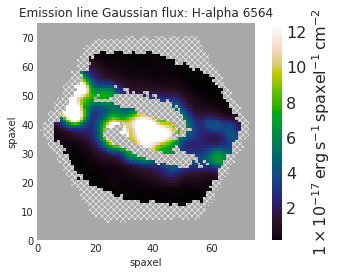

In [18]:
gal.hamap.plot(mask = gal.hamap_non_spiral_mask)

In [19]:
from copy import deepcopy

In [6]:
boolean = np.zeros(gal.hamap.shape, dtype=bool)

In [7]:
a, b = gal.hamap.shape

In [8]:
j, i = (a-1)/2, (b-1)/2

In [9]:
for y, x in [(y, x) for y in range(a) for x in range(b)]:
    if ((y - j)**2 + (x - i)**2) ** 0.5 < 5:
        boolean[y, x] = True

In [12]:
centre_mask = boolean * 2**30

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6df352a9e8>)

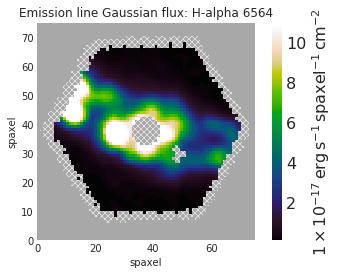

In [13]:
gal.hamap.plot(mask=centre_mask)

In [19]:
df

,radius,ha_flux,sig_ha_flux,hb_flux,sig_hb_flux,spaxel_type,r_re,sfr,sig_sfr
25,18.0,7.076798,0.056828,1.773094,0.044039,Spiral,0.987530,0.026422,0.001705
26,18.0,6.585953,0.060325,1.635627,0.048613,Spiral,0.987530,0.025107,0.001923
27,18.0,6.000990,0.058792,1.479081,0.046376,Spiral,0.987530,0.023290,0.001886
41,15.0,7.616879,0.062551,2.069887,0.044994,Spiral,0.822941,0.023478,0.001368
42,15.0,8.481846,0.074248,2.258485,0.054873,Spiral,0.822941,0.027431,0.001768
43,15.0,8.915937,0.078444,2.283672,0.055609,Spiral,0.822941,0.031602,0.002042
44,16.0,8.715794,0.066421,2.199287,0.047932,Spiral,0.877804,0.032002,0.001839
45,16.0,8.348157,0.060305,2.036358,0.046639,Spiral,0.877804,0.033203,0.001967
46,17.0,7.822111,0.059795,1.778054,0.044720,Spiral,0.932667,0.036747,0.002377
47,17.0,7.130287,0.064915,1.678188,0.049589,Spiral,0.932667,0.030856,0.002350
